In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/volleyball-ball-object-detection-dataset/README.dataset.txt
/kaggle/input/volleyball-ball-object-detection-dataset/README.roboflow.txt
/kaggle/input/volleyball-ball-object-detection-dataset/data.yaml
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_two_mp4-0196_jpg.rf.64cb9c0c3619e01eff7fd9aa894f70a7.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_two_mp4-0017_jpg.rf.fb1f026cb300cf495591dd40c59b9f87.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_four_mp4-0032_jpg.rf.e21eb2efba5101dbf10079c83084fcae.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_four_mp4-0173_jpg.rf.0acd051c1e019402621ca7a564d64cd8.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_two_mp4-0186_jpg.rf.1cb15f0d74534b97ead27d47a31ce268.txt
/kaggle/input/volleyball-ball-object-detection-dataset/valid/labels/clip_three_mp4-0189_jpg.rf.fdfe1a089937bbe1f7d76174cbb0f411.txt
/k

**Build Volleyball Ball Object Detection Project**


**Step 1: Setup Environment**

In [2]:
!pip install ultralytics  # For YOLOv8
!pip install roboflow     # If you need to download datasets from Roboflow
!pip install matplotlib   # For visualization
!pip install opencv-python # For image processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.8/914.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


**Load and Explore the Dataset**

In [3]:
from ultralytics import YOLO
import cv2
import os

# Path to the dataset
data_yaml_path = "/kaggle/input/volleyball-ball-object-detection-dataset/data.yaml"

# Verify the dataset
with open(data_yaml_path, 'r') as file:
    print(file.read())

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['ball']

roboflow:
  workspace: primaryws
  project: volleyball_ball_object_detection_dataset
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/primaryws/volleyball_ball_object_detection_dataset/dataset/1


**Visualize Some Images:**

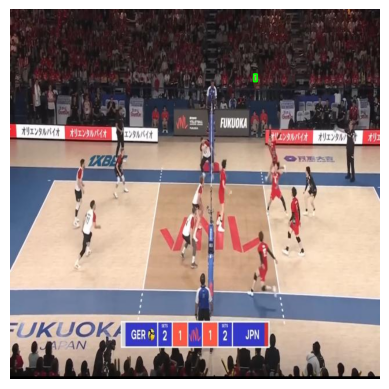

In [4]:
import cv2
import matplotlib.pyplot as plt

# Path to the image
image_path = "/kaggle/input/volleyball-ball-object-detection-dataset/train/images/clip_four_mp4-0002_jpg.rf.eff0a462dfa5ac427272d5cc5c157e1d.jpg"

# Path to the corresponding annotation file
annotation_path = "/kaggle/input/volleyball-ball-object-detection-dataset/train/labels/clip_four_mp4-0002_jpg.rf.eff0a462dfa5ac427272d5cc5c157e1d.txt"

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
image_height, image_width, _ = image.shape  # Get image dimensions

# Load the annotations
with open(annotation_path, 'r') as file:
    annotations = file.readlines()  # Read all lines in the annotation file

# Parse the annotations and draw bounding boxes
for ann in annotations:
    # Split the annotation into components
    class_id, x_center, y_center, width, height = map(float, ann.split())
    
    # Convert YOLO format to image coordinates
    x_center *= image_width  # Convert normalized x_center to pixel value
    y_center *= image_height  # Convert normalized y_center to pixel value
    width *= image_width  # Convert normalized width to pixel value
    height *= image_height  # Convert normalized height to pixel value
    
    # Calculate top-left and bottom-right corners of the bounding box
    x1 = int(x_center - width / 2)  # Top-left x-coordinate
    y1 = int(y_center - height / 2)  # Top-left y-coordinate
    x2 = int(x_center + width / 2)  # Bottom-right x-coordinate
    y2 = int(y_center + height / 2)  # Bottom-right y-coordinate
    
    # Draw the bounding box on the image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle with thickness 2

# Display the image with bounding boxes
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()


In [5]:
# Load a pre-trained YOLOv8 model
model = YOLO("yolov8x.pt")  # Use yolov8x for better accuracy

100%|██████████| 131M/131M [00:00<00:00, 297MB/s]


In [6]:
# Train the model
results = model.train(data=data_yaml_path, epochs=20, imgsz=640, batch=16, name="volleyball_ball_detection")

Ultralytics 8.3.72 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/kaggle/input/volleyball-ball-object-detection-dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=volleyball_ball_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 77.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/volleyball-ball-object-detection-dataset/train/labels... 521 images, 2 backgrounds, 0 corrupt: 100%|██████████| 521/521 [00:01<00:00, 270.83it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/volleyball-ball-object-detection-dataset/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/volleyball-ball-object-detection-dataset/valid/labels... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<00:00, 254.12it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/volleyball-ball-object-detection-dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/volleyball_ball_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/volleyball_ball_detection
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      13.2G      2.928      31.04      1.003         11        640: 100%|██████████| 33/33 [00:38<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         27         27          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20        13G      2.695      3.152     0.9601         10        640: 100%|██████████| 33/33 [00:37<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         27         27          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20        13G      2.862      1.922      1.016         11        640: 100%|██████████| 33/33 [00:37<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         27         27          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      13.2G      2.764      1.507     0.9682         13        640: 100%|██████████| 33/33 [00:38<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

                   all         27         27          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20        13G       2.51      1.391     0.9327         11        640: 100%|██████████| 33/33 [00:38<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         27         27      0.058      0.333      0.036     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      13.3G      2.357       1.21     0.9066         13        640: 100%|██████████| 33/33 [00:38<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         27         27      0.813      0.704      0.731      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      13.2G      2.354      1.229     0.9058         11        640: 100%|██████████| 33/33 [00:39<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         27         27       0.88      0.852      0.864      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      13.2G      2.115      1.125     0.8822         12        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         27         27      0.996      0.852      0.946      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20        13G      2.216      1.039     0.8951         16        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         27         27      0.991      0.926      0.963      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      13.3G      2.119      1.053     0.8822         13        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         27         27      0.976      0.519      0.595      0.286


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      13.2G      1.911     0.9272     0.8846          9        640: 100%|██████████| 33/33 [00:39<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         27         27      0.984      0.889      0.974      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      13.2G      1.781     0.8024     0.8838          8        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         27         27       0.93      0.985      0.982      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20        13G      1.833     0.8943     0.8776          9        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         27         27      0.997      0.926      0.984      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      13.3G      1.825     0.8481     0.8711          8        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         27         27      0.958      0.963      0.976      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      13.2G      1.721      0.787     0.8575          8        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         27         27      0.989      0.926      0.972      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      13.2G      1.731      0.803     0.8477          8        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         27         27      0.993      0.926      0.978      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20        13G      1.629     0.6877     0.8449          8        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         27         27      0.995      0.926      0.987       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      13.3G      1.598     0.7206     0.8416          7        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         27         27      0.989      0.926      0.978      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      13.2G      1.533     0.6723     0.8567          8        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         27         27      0.999      0.926      0.991      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      13.2G       1.48     0.6671     0.8344          9        640: 100%|██████████| 33/33 [00:39<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         27         27      0.996      0.926      0.978      0.547



20 epochs completed in 0.238 hours.
Optimizer stripped from runs/detect/volleyball_ball_detection/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/volleyball_ball_detection/weights/best.pt, 136.7MB

Validating runs/detect/volleyball_ball_detection/weights/best.pt...
Ultralytics 8.3.72 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


                   all         27         27      0.999      0.926      0.991      0.597


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 29.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/volleyball_ball_detection


**Evaluate the Model**

**1.Check Training Metrics**

After training, evaluate the model's performance using validation data.

In [7]:
# Evaluate the model
metrics = model.val()
print(metrics)

Ultralytics 8.3.72 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /kaggle/input/volleyball-ball-object-detection-dataset/valid/labels... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<00:00, 685.29it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/volleyball-ball-object-detection-dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


                   all         27         27      0.999      0.926      0.991      0.602


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 67.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/volleyball_ball_detection2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f52ae2bf8b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038

**2.Visualize Predictions:**

Test the model on a few validation images and visualize the predictions.


image 1/1 /kaggle/input/volleyball-ball-object-detection-dataset/valid/images/clip_one_mp4-0051_jpg.rf.ade500962f01e6721ed38c562b26897f.jpg: 640x640 1 ball, 80.4ms
Speed: 3.2ms preprocess, 80.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/volleyball_ball_detection3


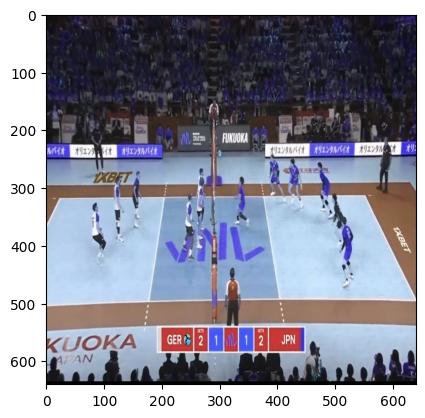

In [8]:
# Test the model on a validation image
results = model.predict(source="/kaggle/input/volleyball-ball-object-detection-dataset/valid/images/clip_one_mp4-0051_jpg.rf.ade500962f01e6721ed38c562b26897f.jpg", save=True)

# Display the predicted image
predicted_image = cv2.imread("/kaggle/input/volleyball-ball-object-detection-dataset/valid/images/clip_one_mp4-0060_jpg.rf.9b25254faca4e7f4972d5ba80a61ea34.jpg")
plt.imshow(predicted_image)
plt.show()

In [9]:
metrics = model.val()
print(metrics.box.map)  # mAP score

Ultralytics 8.3.72 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/input/volleyball-ball-object-detection-dataset/valid/labels... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<00:00, 946.82it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/volleyball-ball-object-detection-dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


                   all         27         27      0.999      0.926      0.991      0.602


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 66.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/volleyball_ball_detection4
0.6018187297191762
